In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from pricing import EquityForwardCurve, ForwardVariance, DiscountingCurve,piecewise_function,Vanilla_PayOff,PricingModel, ACT_365, ACT_360
from scipy import exp, sqrt, log
from scipy.interpolate import interp1d
import time, sys
from montecarlo import MC_Analisys, MC
from matplotlib import ticker
from targetvol import time_grid_union, Drift, CholeskyTDependent, Strategy,TVSForwardCurve ,TargetVolatilityStrategy,TargetVolatilityEuler,Markowitz_solution,loss_function
from numpy.linalg import cholesky

In [2]:
tree = ET.parse('TV_example.xml')
root = tree.getroot()
for child in root:
    print(child.tag, child.attrib)

b {'name': 'engine'}
node {'name': 'model'}
node {'name': 'payoff'}
node {'name': 'market'}
node {'name': 'config'}


#### Correlation matrix

In [3]:
N_equity = len(root[3][0][1][1][1][0])
print(root[3][0][1].attrib)
print(root[3][0][1][1][0].attrib)
print(root[3][0][1][1][0][0].attrib)
print("\n")
correlation_matrix = np.zeros(N_equity*N_equity)
for i in range (N_equity*N_equity):
    correlation_matrix[i] = float(root[3][0][1][1][0][0][i].text)

correlation_matrix = np.reshape(correlation_matrix, (N_equity,N_equity)) 
"""Delete cash bank"""
delete_equity = [0,11,12,13,14,15]
correlation_matrix = np.delete(correlation_matrix,delete_equity, axis = 0)
correlation_matrix = np.delete(correlation_matrix,delete_equity, axis = 1)

print(root[3][0][1][1][1].attrib)
names = np.array([])
for i in range(N_equity):
    names=np.append(names,root[3][0][1][1][1][0][i].text)
names =np.delete(names,delete_equity)
print("Equities: ",names)
N_equity = len(names)
correlation_matrix

{'name': 'correlation_matrix'}
{'name': 'correlations'}
{'type': 'double', 'rows': '16', 'cols': '16'}


{'name': 'names'}
Equities:  ['DJ 50 TR' 'S&P 500 NET EUR' 'MSCI EM MKT EUR' 'I NKY NTR EUR'
 'FTSE100 NTR E' 'SMI TR EUR' 'DAX 30 E' 'FTSEMIBN' 'CAC 40 NTR'
 'HSI NTR EUR']


array([[1.  , 0.82, 0.86, 0.86, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.82, 1.  , 0.75, 0.77, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.86, 0.75, 1.  , 0.77, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.86, 0.77, 0.77, 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]])

#### Discounting curve


In [4]:
print(root[3][1][0].attrib)
print(root[3][1][0][0][0][0].attrib)
print(root[3][1][0][0][0][1].attrib)
print(root[3][1][0][0][0][0][0].attrib)

discounts = np.zeros(len(root[3][1][0][0][0][0][0]))
discounts_dates = np.zeros(len(root[3][1][0][0][0][0][0]))

for i in range(len(root[3][1][0][0][0][0][0])):
    discounts_dates[i] = float(root[3][1][0][0][0][0][0][i].text)
    discounts[i] = float(root[3][1][0][0][0][1][0][i].text)


print(root[3][1][0][0][2].attrib)
reference_date = float(root[3][1][0][0][2][0].text)
print("Reference date: ",reference_date)
print("\n")
D = DiscountingCurve(reference=reference_date, discounts=discounts, dates=discounts_dates)

{'name': 'zero_curve'}
{'name': 'dates'}
{'name': 'discounts'}
{'type': 'long', 'size': '65'}
{'name': 'reference_date'}
Reference date:  44005.0


zero interest rate time grid [0.00000000e+00 2.73972603e-03 5.47945205e-03 8.21917808e-03
 2.46575342e-02 4.38356164e-02 6.30136986e-02 9.31506849e-02
 1.72602740e-01 2.57534247e-01 3.42465753e-01 4.24657534e-01
 5.15068493e-01 5.91780822e-01 6.76712329e-01 7.31506849e-01
 7.53424658e-01 9.83561644e-01 1.00547945e+00 1.23287671e+00
 1.47945205e+00 1.72602740e+00 1.98082192e+00 2.01095890e+00
 2.23013699e+00 3.00821918e+00 4.00821918e+00 5.00821918e+00
 6.00821918e+00 7.00821918e+00 8.01369863e+00 9.01095890e+00
 1.00109589e+01 1.10109589e+01 1.20136986e+01 1.30191781e+01
 1.40164384e+01 1.50136986e+01 1.60164384e+01 1.70164384e+01
 1.80164384e+01 1.90219178e+01 2.00191781e+01 2.10191781e+01
 2.20191781e+01 2.30191781e+01 2.40273973e+01 2.50246575e+01
 2.60219178e+01 2.70219178e+01 2.80246575e+01 2.90246575e+01
 3.00301370e+01 3.10273973e+01

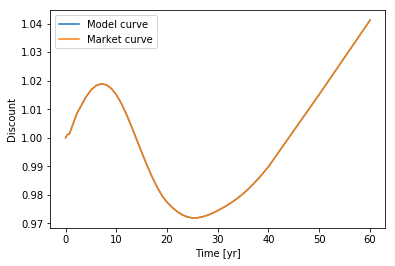

In [5]:
plt.plot(ACT_365(discounts_dates,reference_date), D(ACT_365(discounts_dates,reference_date)), label="Model curve")
plt.plot(ACT_365(discounts_dates,reference_date), discounts, label='Market curve')
plt.legend()
plt.xlabel("Time [yr]")
plt.ylabel("Discount")
plt.show()

#### Equity spot prices

In [6]:
index_equity = [1,2,3,4,5,6,7,8,9,10]
spot_prices = np.zeros(len(index_equity))
j = 0
for i in index_equity:  
    #print(root[3][i+3].attrib)
    if i>=6:  
        spot_prices[j] = float(root[3][i+3][0][1][0][0].text)
        #print(root[3][i+3][0][1][0].attrib)
    else:
        spot_prices[j] = float(root[3][3+i][0][0][1][0].text)
        #print(root[3][3+i][0][0][1].attrib)
    j = j+1

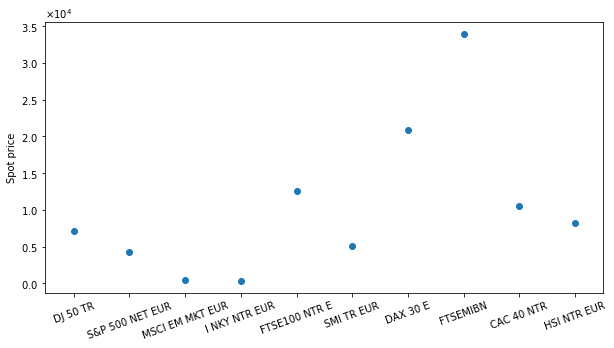

Spot prices:  [ 7084.62        4226.3168       405.06122627   284.5478
 12501.29        5105.69271854 20863.4254     33970.46
 10587.37        8238.3056    ]


In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.xticks([1, 2, 3,4,5,6,7,8,9,10], names,rotation=20)  # Set text labels and properties.
plt.scatter([1, 2, 3,4,5,6,7,8,9,10],spot_prices)
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter)
plt.ylabel("Spot price")
plt.show()
print("Spot prices: ",spot_prices)

#### Equity repo rates and Forward curves

In [8]:
F = []
max_dates = np.array([])
index = 0
for i in index_equity:
    print(root[3][i+3].attrib)
    if i>=6:  #for those equity there aren't repo rates so we put them to 0 over the time
        repo_dates = np.array([reference_date+1, np.max(max_dates)])
        repo_rates = np.zeros(2)
        print(repo_rates)
        F.append(EquityForwardCurve(reference=reference_date, discounting_curve=D, repo_dates=repo_dates,repo_rates=repo_rates, spot=spot_prices[index]))
        print("\n")
    else:
        #print(root[3][i+3][0][0][0][0].attrib)
        #print(root[3][i+3][0][0][0][1].attrib)
        repo_dates = np.zeros(len(root[3][3+i][0][0][0][0][0]))
        repo_rates = np.zeros(len(root[3][3+i][0][0][0][1][0]))
        for j in range (len(root[3][3+i][0][0][0][0][0])):
            repo_dates[j] = float(root[3][3+i][0][0][0][0][0][j].text)
            repo_rates[j] = float(root[3][3+i][0][0][0][1][0][j].text)
        print(repo_rates)
        max_dates = np.append(max_dates,np.max(repo_dates))
        F.append(EquityForwardCurve(reference=reference_date, discounting_curve=D, repo_dates=repo_dates,repo_rates=repo_rates, spot=spot_prices[index]))
        print("\n")
    index = index+1

"""Check if the forward curve at reference date is equal to the spot price"""    
for i in range(N_equity):
    if F[i](0)!=spot_prices[i]:
        print("Error equity ",i)

{'name': 'DJ 50 TR'}
[0.0039 0.0039 0.0041 0.0042 0.0041 0.004  0.0039]
Forward repo time grid [0.         0.49444444 1.50555556 2.51666667 3.52777778 4.55833333
 5.56944444]
Forward repo rate:  [0.0039     0.0039     0.0041978  0.0043489  0.0038511  0.00365768
 0.00344918]


{'name': 'S&P 500 NET EUR'}
[-0.002 -0.002 -0.002 -0.002 -0.002 -0.002 -0.002]
Forward repo time grid [0.         0.49444444 1.50555556 2.51666667 3.52777778 4.55833333
 5.56944444]
Forward repo rate:  [-0.002 -0.002 -0.002 -0.002 -0.002 -0.002 -0.002]


{'name': 'MSCI EM MKT EUR'}
[-0.002 -0.002 -0.002 -0.002 -0.002 -0.002 -0.002]
Forward repo time grid [0.         0.49444444 1.50555556 2.51666667 3.52777778 4.55833333
 5.56944444]
Forward repo rate:  [-0.002 -0.002 -0.002 -0.002 -0.002 -0.002 -0.002]


{'name': 'I NKY NTR EUR'}
[-0.002 -0.002 -0.002 -0.002 -0.002 -0.002 -0.002]
Forward repo time grid [0.         0.49444444 1.50555556 2.51666667 3.52777778 4.55833333
 5.56944444]
Forward repo rate:  [-0.002 -0.00

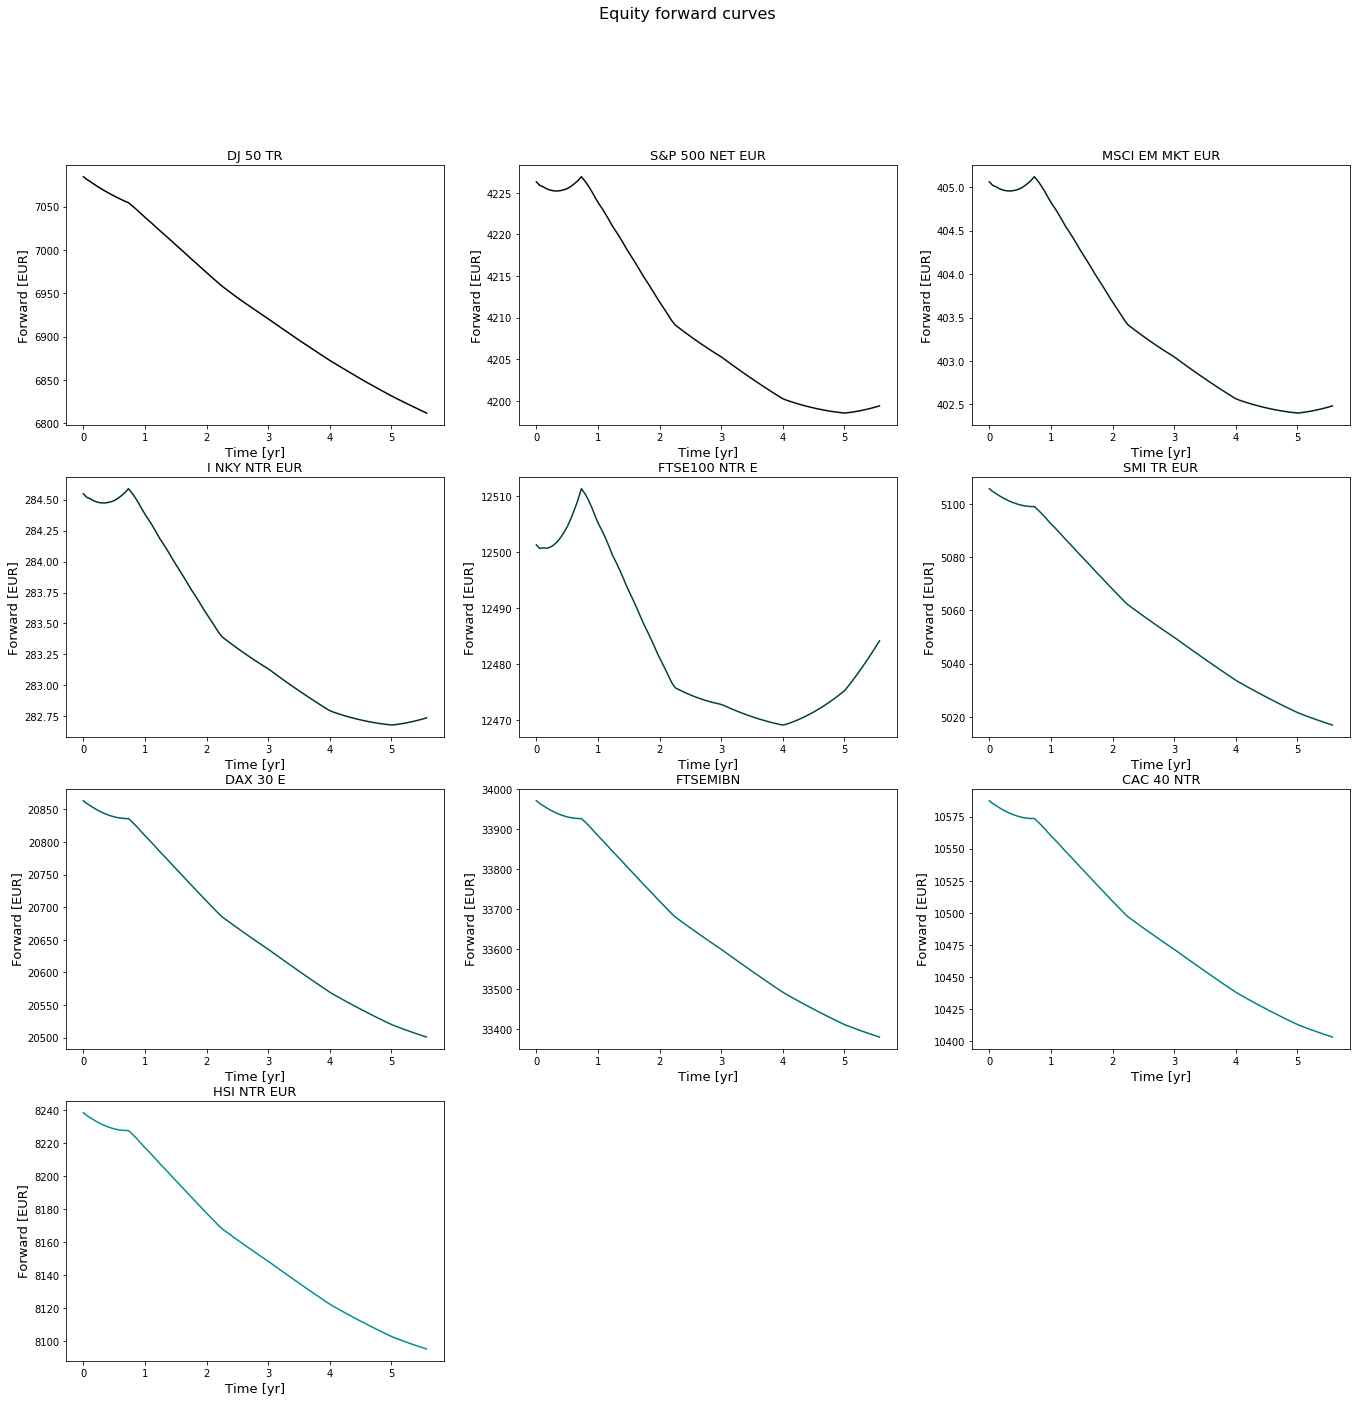

In [9]:
x = np.linspace(0,ACT_360(reference_date,np.max(max_dates)),100)
plt.figure(figsize=(23,22))
plt.suptitle('Equity forward curves',fontsize=16) 
for i in range(N_equity):
    plt.subplot(4,3,i+1)
    plt.plot(x, F[i](x),'#00'+str(i)+'0'+str(i)+'0')
    plt.title(names[i], fontsize = 13)
    plt.xlabel("Time [yr]", fontsize = 13)
    plt.ylabel("Forward [EUR]", fontsize = 13)
plt.show()

#### Spot volatilities

In [10]:
V = []
index = 0
index_equity = [1,2,3,4,5,6,7,8,9,10]
for i in index_equity:
    vola_dates = np.zeros(len(root[3][i+3][1][2][0][0]))
    vola_strikes = np.zeros(len(root[3][i+3][1][2][2][0]))
    for j in range(len(root[3][i+3][1][2][0][0])):
        vola_dates[j] = float(root[3][i+3][1][2][0][0][j].text)

    for j in range(len(root[3][i+3][1][2][2][0])):   
        vola_strikes[j] = float(root[3][i+3][1][2][2][0][j].text)

    spot_volatilities = np.zeros(len(root[3][i+3][1][2][0][0])*len(root[3][i+3][1][2][2][0]))
    for k in range (len(spot_volatilities)):
        spot_volatilities[k] = float(root[3][i+3][1][2][1][0][k].text)
    spot_volatilities = np.reshape(spot_volatilities,(len(vola_dates),len(vola_strikes)))
    V.append(ForwardVariance(reference=reference_date, spot_volatility=spot_volatilities, maturities=vola_dates, strikes=vola_strikes, forward=F[index]))
    print("\n")
    index = index+1

Forward volatility time grid:  [ 0.06575342  0.16164384  0.23835616  0.48767123  0.7369863   0.98630137
  1.48493151  1.98356164  2.48219178  3.47945205  4.49589041  5.49315068
  6.49041096  7.48767123  8.48493151  9.50136986 10.49863014]
Forward volatility:  [0.17968289 0.17870522 0.17748225 0.17470943 0.17520606 0.17492458
 0.17674074 0.1778676  0.17908349 0.18003412 0.18282872 0.18039984
 0.17938685 0.17963664 0.17948161 0.17787179 0.17699042]


Forward volatility time grid:  [0.06575342 0.16164384 0.23835616 0.48767123 0.56438356 0.7369863
 0.98630137 1.48493151 1.58082192 1.98356164 2.48219178 3.47945205
 4.49589041 4.57260274 5.56986301 7.48767123]
Forward volatility:  [0.23322252 0.24209823 0.25181046 0.24987572 0.22098048 0.22660849
 0.21462688 0.20123583 0.21178323 0.20566381 0.19995376 0.20156554
 0.21512117 0.24636786 0.26956897 0.27248953]


Forward volatility time grid:  [0.06575342 0.16164384 0.23835616 0.56438356 0.7369863  0.98630137
 1.58082192 1.98356164 2.57808219 3.

In [11]:
mu = Drift(F)
print("\n")
nu = CholeskyTDependent(V,correlation_matrix)

Drift time grid: [0.00000000e+00 2.77777778e-03 4.94444444e-01 1.50555556e+00
 2.51666667e+00 3.52777778e+00 4.55833333e+00 5.56944444e+00]
Drift values: [[ 0.0039     -0.002      -0.002      -0.002      -0.0029      0.
   0.          0.          0.          0.        ]
 [ 0.0039     -0.002      -0.002      -0.002      -0.0029     -0.
  -0.         -0.         -0.         -0.        ]
 [ 0.0039     -0.002      -0.002      -0.002      -0.0029      0.
   0.          0.          0.          0.        ]
 [ 0.0041978  -0.002      -0.002      -0.002      -0.0029      0.
   0.          0.          0.          0.        ]
 [ 0.0043489  -0.002      -0.002      -0.002      -0.0029      0.
   0.          0.          0.          0.        ]
 [ 0.0038511  -0.002      -0.002      -0.002      -0.0029      0.
   0.          0.          0.          0.        ]
 [ 0.00365768 -0.002      -0.002      -0.002      -0.0029      0.
   0.          0.          0.          0.        ]
 [ 0.00344918 -0.002      -

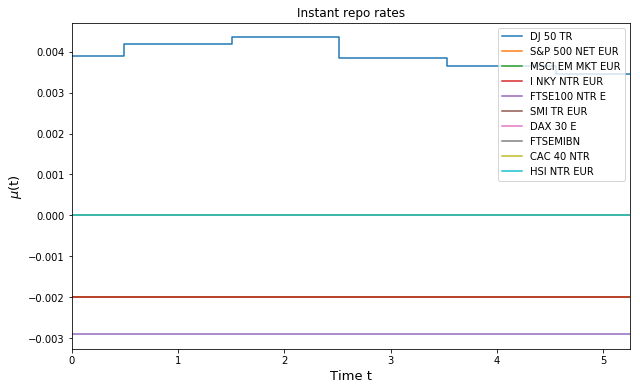

In [12]:
x = np.linspace(0,nu.T[len(nu.T)-1],150)
dimension_points = 12
plt.figure(figsize=(10,6))
for i in range(N_equity):
    plt.step(F[i].T,F[i].q,label=names[i])
    
plt.legend()
plt.title('Instant repo rates')
plt.xlabel("Time t", fontsize = 13)
plt.ylabel(r"$\mu$(t)", fontsize = 13)
plt.xlim(0,nu.T[len(nu.T)-1])
plt.show()

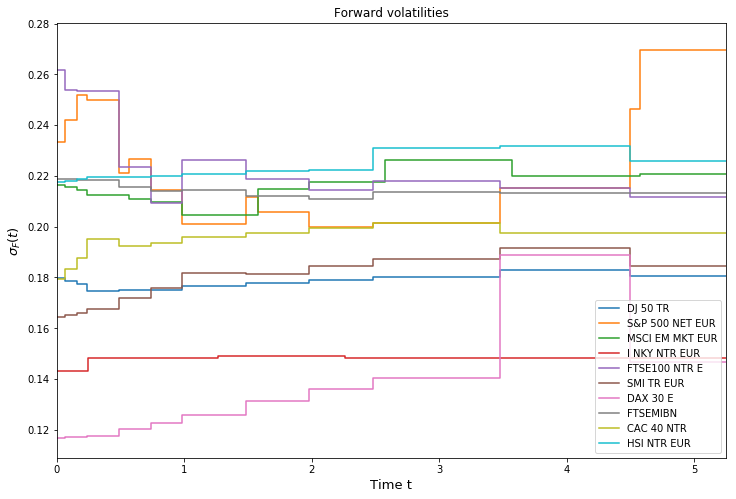

In [13]:
plt.figure(figsize=(12,8))
plt.title('Forward volatilities')
for i in range(N_equity):
    time = V[i].T.tolist()
    vola = V[i].forward_vol.tolist()
    time.insert(0,V[i].T[0])
    time.insert(0,0)
    vola.insert(0,V[i].forward_vol[0])
    vola.insert(0,V[i].forward_vol[0])
    plt.step(time,vola,label=names[i],where='pre')
plt.legend()
plt.xlabel("Time t",fontsize = 13)
plt.ylabel(r"$\sigma_{F}(t)$",fontsize = 13)
plt.xlim(0,nu.T[len(nu.T)-1])
plt.show()

In [14]:
alpha = Strategy()
alpha.Mark_strategy(mu=mu,nu=nu)

Markowitz strategy time grid : [0.00000000e+00 2.77777778e-03 6.57534247e-02 1.61643836e-01
 2.38356164e-01 2.46575342e-01 4.87671233e-01 4.94444444e-01
 5.64383562e-01 7.36986301e-01 9.86301370e-01 1.26301370e+00
 1.48493151e+00 1.50555556e+00 1.58082192e+00 1.98356164e+00
 2.26027397e+00 2.48219178e+00 2.51666667e+00 2.57808219e+00
 3.25753425e+00 3.47945205e+00 3.52777778e+00 3.57534247e+00
 4.25479452e+00 4.49589041e+00 4.55833333e+00 4.57260274e+00
 5.25205479e+00]
Markowitz strategy :  [[-14.28899171   2.36238386   4.58610468   8.24073467   0.48443193
   -0.          -0.          -0.          -0.          -0.        ]
 [-14.28899171   2.36238386   4.58610468   8.24073467   0.48443193
   -0.          -0.          -0.          -0.          -0.        ]
 [-14.28899171   2.36238386   4.58610468   8.24073467   0.48443193
   -0.          -0.          -0.          -0.          -0.        ]
 [-14.35819215   2.23014281   4.62517176   8.26313032   0.5136404
   -0.          -0.          -0.

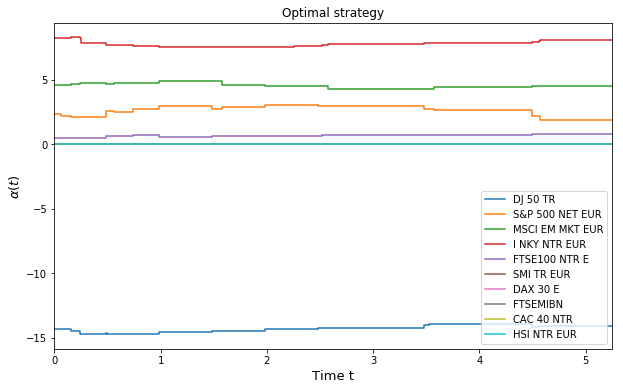

In [15]:
plt.figure(figsize=(10,6))
plt.title("Optimal strategy")
for i in range(N_equity):
    plt.step(alpha.T,alpha.alpha_t.T[i],label=names[i])
plt.legend()
plt.xlabel("Time t",fontsize=13)
plt.ylabel(r"$\alpha(t)$",fontsize =13)
plt.xlim(0,alpha.T[len(alpha.T)-1])
plt.show()

In [16]:
I_0 = np.sum(spot_prices)
vol_target = 1/N_equity*sqrt(np.sum(nu(0)@nu(0).T))
print("Target volatility: ",vol_target)
dates = alpha.T
dates = np.delete(dates,len(alpha.T)-1)
dates = np.append(dates,alpha.T[len(alpha.T)-1]-0.00001)
K = I_0   #ATM pricing
simulations = 1e6
kind = 1 #call option
print("Spot price ",I_0)
print("Dates ",dates)

Target volatility:  0.08631132203436905
Spot price  103267.08954481399
Dates  [0.00000000e+00 2.77777778e-03 6.57534247e-02 1.61643836e-01
 2.38356164e-01 2.46575342e-01 4.87671233e-01 4.94444444e-01
 5.64383562e-01 7.36986301e-01 9.86301370e-01 1.26301370e+00
 1.48493151e+00 1.50555556e+00 1.58082192e+00 1.98356164e+00
 2.26027397e+00 2.48219178e+00 2.51666667e+00 2.57808219e+00
 3.25753425e+00 3.47945205e+00 3.52777778e+00 3.57534247e+00
 4.25479452e+00 4.49589041e+00 4.55833333e+00 4.57260274e+00
 5.25204479e+00]


In [17]:
%%time
TVSF = TVSForwardCurve(reference = 0., vola_target =vol_target, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,np.max(dates)]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
print("Path simulation")
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
print("Payoff")
pay = Vanilla_PayOff(St=I_t,strike=K, typo=kind)*D(dates)
print("Data blocking")
x, result_mark, result_err_mark = MC_Analisys(pay[:,len(dates)-1],100)

Path simulation
Martingale simulation
Forward calculation
Payoff
Data blocking
Wall time: 8min 32s


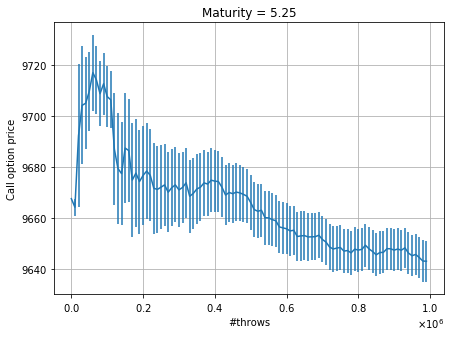

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,result_mark,yerr=result_err_mark)
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
if kind ==1:
    plt.ylabel("Call option price")
#    plt.savefig("TVS_call_option_price.pdf")
if kind == -1:
    plt.ylabel("Put option price")
#    plt.savefig("TVS_put_option_price.pdf")
    
plt.show()

In [19]:
%%time
alpha.optimization_constrained(mu=mu,nu=nu,N_trial=100)
TVSF = TVSForwardCurve(reference = 0., vola_target =vol_target, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,np.max(dates)]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
print("Path simulation")
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
print("Payoff")
pay = Vanilla_PayOff(St=I_t,strike=K, typo=kind)*D(dates)
print("Data blocking")
x, result_opt1, result_err_opt1 = MC_Analisys(pay[:,len(dates)-1],100)

Minumum:  -0.01783864756841496
Minumum:  -0.01783864756841496
Minumum:  -0.017838647568189224
Minumum:  -0.018054008567685676
Minumum:  -0.018056455616831273
Minumum:  -0.018058059321856678
Minumum:  -0.017674826319432946
Minumum:  -0.018701708590212827
Minumum:  -0.018701713134070406
Minumum:  -0.018701713352054058
Minumum:  -0.01931649256412056
Minumum:  -0.018603217587852043
Minumum:  -0.018566415984873262
Minumum:  -0.01886940854084861
Minumum:  -0.018869421640500223
Minumum:  -0.018869420315105478
Minumum:  -0.019061071222903413
Minumum:  -0.019117452146743784
Minumum:  -0.018949288892901518
Minumum:  -0.018949288763536028
Minumum:  -0.018949294280820903
Minumum:  -0.018949294280974652
Minumum:  -0.019068649776748905
Minumum:  -0.019068649776087753
Minumum:  -0.01906865012082944
Minumum:  -0.01906865012083828
Minumum:  -0.019234347918444965
Minumum:  -0.01923434791761509
Minumum:  -0.019234347887111418
Optimal strategy time grid : [0.00000000e+00 2.77777778e-03 6.57534247e-02 1.61

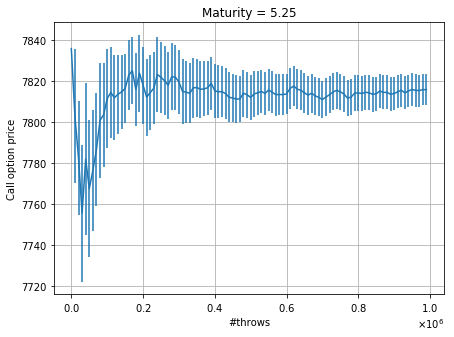

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,result_opt1,yerr=result_err_opt1)
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
if kind ==1:
    plt.ylabel("Call option price")
#    plt.savefig("TVS_call_option_price.pdf")
if kind == -1:
    plt.ylabel("Put option price")
#    plt.savefig("TVS_put_option_price.pdf")
    
plt.show()

In [21]:
%%time
alpha.optimization_constrained(mu=mu,nu=nu,N_trial=100,typo=2)
TVSF = TVSForwardCurve(reference = 0., vola_target =vol_target, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,np.max(dates)]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
print("Path simulation")
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
print("Payoff")
pay = Vanilla_PayOff(St=I_t,strike=K, typo=kind)*D(dates)
print("Data blocking")
x, result_opt2, result_err_opt2 = MC_Analisys(pay[:,len(dates)-1],100)

Minumum:  -0.08751036484914033
Minumum:  -0.08751036484914033
Minumum:  -0.08751036484912857
Minumum:  -0.08772339168584299
Minumum:  -0.08797833790467206
Minumum:  -0.08900210510094113
Minumum:  -0.08841629649877518
Minumum:  -0.08904588689219342
Minumum:  -0.09341129516045588
Minumum:  -0.09335258437821674
Minumum:  -0.0939114116604566
Minumum:  -0.09374223740874242
Minumum:  -0.09368516300809995
Minumum:  -0.09306628660193766
Minumum:  -0.09525066902608244
Minumum:  -0.09494104108107078
Minumum:  -0.09461175055548834
Minumum:  -0.09470188492690503
Minumum:  -0.09428998733874178
Minumum:  -0.0871939425684933
Minumum:  -0.08684894791141663
Minumum:  -0.0868489479114666
Minumum:  -0.08566612535056212
Minumum:  -0.08296246828464794
Minumum:  -0.08320879067417992
Minumum:  -0.08320879067048263
Minumum:  -0.08327523749302695
Minumum:  -0.08032964730059454
Minumum:  -0.07992850458995303
Optimal strategy time grid : [0.00000000e+00 2.77777778e-03 6.57534247e-02 1.61643836e-01
 2.38356164e-0

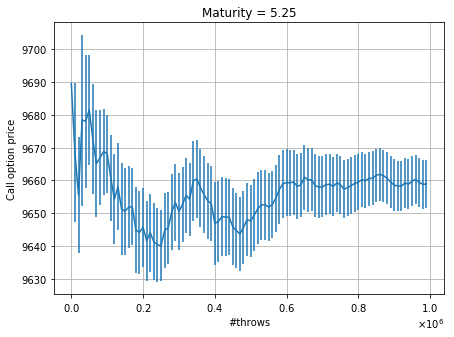

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,result_opt2,yerr=result_err_opt2)
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
if kind ==1:
    plt.ylabel("Call option price")
#    plt.savefig("TVS_call_option_price.pdf")
if kind == -1:
    plt.ylabel("Put option price")
#    plt.savefig("TVS_put_option_price.pdf")
    
plt.show()

In [23]:
%%time
alpha.optimization_constrained(mu=mu,nu=nu,N_trial=100,typo=3)
TVSF = TVSForwardCurve(reference = 0., vola_target =vol_target, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,np.max(dates)]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
print("Path simulation")
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
print("Payoff")
pay = Vanilla_PayOff(St=I_t,strike=K, typo=kind)*D(dates)
print("Data blocking")
x, result_opt3, result_err_opt3 = MC_Analisys(pay[:,len(dates)-1],100)

Minumum:  -0.08751036668818943
Minumum:  -0.08751036668818943
Minumum:  -0.08751036668820199
Minumum:  -0.08772339631307646
Minumum:  -0.08797834231473783
Minumum:  -0.08900211008786693
Minumum:  -0.08841630268338542
Minumum:  -0.08904588992316662
Minumum:  -0.09341129872235619
Minumum:  -0.09335258515445717
Minumum:  -0.09391141571968185
Minumum:  -0.09374223967983986
Minumum:  -0.09368517173284975
Minumum:  -0.09306629252155701
Minumum:  -0.09525068267725409
Minumum:  -0.09494104202456452
Minumum:  -0.09461176284768613
Minumum:  -0.09470189204859121
Minumum:  -0.09428998986299829
Minumum:  -0.08719394396738885
Minumum:  -0.0868489496982426
Minumum:  -0.08684894969824233
Minumum:  -0.0856661293756412
Minumum:  -0.08296247908062152
Minumum:  -0.08320879640947013
Minumum:  -0.08320879640947022
Minumum:  -0.08327524426403456
Minumum:  -0.08032965219087583
Minumum:  -0.07992850486242582
Optimal strategy time grid : [0.00000000e+00 2.77777778e-03 6.57534247e-02 1.61643836e-01
 2.38356164e-

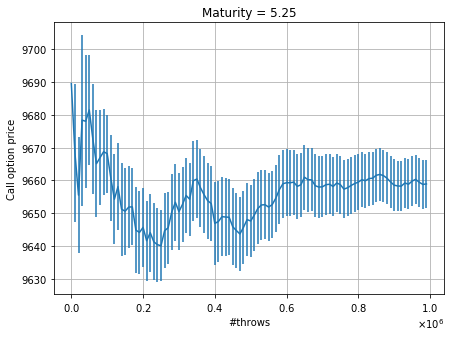

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,result_opt3,yerr=result_err_opt3)
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
if kind ==1:
    plt.ylabel("Call option price")
#    plt.savefig("TVS_call_option_price.pdf")
if kind == -1:
    plt.ylabel("Put option price")
#    plt.savefig("TVS_put_option_price.pdf")
    
plt.show()

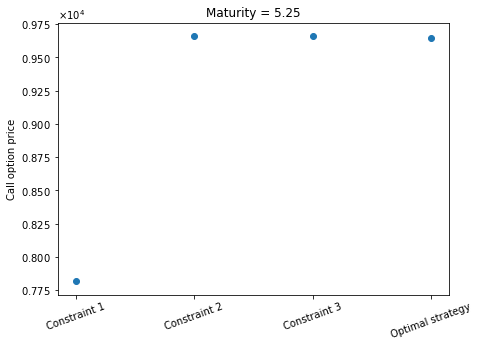

In [25]:
n =len(dates)-1
errori = np.array([result_err_opt1[99],result_err_opt2[99],result_err_opt3[99],result_err_mark[99]])
risultati = err = np.array([result_opt1[99],result_opt2[99],result_opt3[99],result_mark[99]])
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.xticks([1, 2, 3,4], ["Constraint 1","Constraint 2", "Constraint 3", "Optimal strategy"],rotation=20)  # Set text labels and properties.
plt.errorbar([1, 2, 3,4],risultati,errori,fmt='o')
plt.title("Maturity = "+str(round(dates[n],2)))
if kind ==1:
    plt.ylabel("Call option price")
if kind == -1:
    plt.ylabel("Put option price")
ax.yaxis.set_major_formatter(formatter)
#plt.savefig("strategy_comparison.pdf")
plt.show()